## Import libraries

In [3]:
import pandas as pd 
import seaborn as sns 
import numpy as np 

import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import RobustScaler, StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel

from sklearn.model_selection import train_test_split, KFold, cross_val_predict

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_squared_error

import ast

In [4]:
pd.set_option('display.max_columns', 50)

## Load datasets

A quick look into the dataset and we could notice that the special character _"\N"_ is used instead of _NaN_ for missing values.

In [5]:
# X1: entry dataset (note: X2 is the testing dataset)
# use row `Unamed: 0` as the row index
X1 = pd.read_csv("datasets/X1.csv", na_values="\\N")
X1.head()

,Unnamed: 0,title,img_url,description,ratings,n_votes,is_adult,production_year,runtime,genres,release_year,studio,img_embeddings,text_embeddings
0,2502,Letters to Juliet,https://m.media-amazon.com/images/M/MV5BMjg0OT...,Letters to Juliet: Directed by Gary Winick. Wi...,6.5,92937.0,0,2010,105.0,"Adventure,Comedy,Drama",2010.0,Sum.,"[0.25030804, 2.4058464, 1.0431569, 0.030648155...","[-0.6795498, 0.35658365, 0.9994932, -0.9793934..."
1,6238,Veil of Tears,https://m.media-amazon.com/images/M/MV5BZjMxOD...,Veil of Tears: Directed by William Gereghty. W...,7.9,11.0,0,1996,NaN,"Action,Crime,Drama",2014.0,WF,"[0.51250213, 2.8152602, 0.46308166, 0.29031387...","[-0.6202415, 0.31657028, 0.9992422, -0.9703722..."
2,1800,International Velvet,https://m.media-amazon.com/images/M/MV5BOGVkYj...,International Velvet: Directed by Bryan Forbes...,5.9,1345.0,0,1978,127.0,"Drama,Family,Sport",1978.0,MGM,"[0.18073043, 0.24735461, 0.63652813, 0.2496522...","[-0.709996, 0.4233521, 0.99980927, -0.98892415..."
3,2675,8 Seconds,https://m.media-amazon.com/images/M/MV5BYjY4Nz...,8 Seconds: Directed by John G. Avildsen. With ...,6.6,4851.0,0,1994,105.0,"Biography,Drama,Sport",1994.0,NL,"[0.025015268, 0.9105338, 0.3878257, 0.3421247,...","[-0.7416838, 0.38435012, 0.9998453, -0.9874693..."
4,3674,Penitentiary II,https://m.media-amazon.com/images/M/MV5BNjQyZW...,Penitentiary II: Directed by Jamaa Fanaka. Wit...,4.1,549.0,0,1982,108.0,"Crime,Drama,Sport",1982.0,MGM,"[0.19079691, 1.9068279, 0.29114372, 0.19527505...","[-0.65501904, 0.3845747, 0.9996712, -0.9766391..."


In [6]:
#X1.loc[X1["title"] == "Clown"]

inputs dataset has dimension (3540, 14)

One first thing we can notice is that our dataset use a special character "\\N" for empty values. We should modify them to NaN.

In [7]:
# Y1: target dataset
Y1 = pd.read_csv("datasets/Y1.csv", header=None, names=["revenues"])
Y1.head()

,revenues
0,7.158530e+07
1,8.964834e+04
2,3.164907e+07
3,3.898197e+07
4,9.697023e+06


target dataset has dimension (3540, 1)

In [8]:
# X2: testing entry dataset
X2 = pd.read_csv("datasets/X2.csv", na_values="\\N")

In [9]:
print(f"X1 dataset contains {X1.shape[0]} observations and {X1.shape[1]} features")
print(f"X2 dataset (for prediction only) contains {X2.shape[0]} observations")

print(f"features: {list(X1.columns)}")
print(f"target: {list(Y1.columns)}")

X1 dataset contains 3540 observations and 14 features
X2 dataset (for prediction only) contains 1518 observations
features: ['Unnamed: 0', 'title', 'img_url', 'description', 'ratings', 'n_votes', 'is_adult', 'production_year', 'runtime', 'genres', 'release_year', 'studio', 'img_embeddings', 'text_embeddings']
target: ['revenues']


## Dataset description

inputs (X1):     
- `title`: title of the movie.    
- `ratings`: rating on IMDB.    
- `n_votes`: number of votes that are averaged for the given rating.    
- `is_adult`: is the movie destined for a mature audience (0 or 1).    
- `production_year`: the year the movie was produced.    
- `release_year`: the year the movie was released.    
- `runtime`: how long the movie lasts for (in minutes).    
- `genres`: a list of maximum 3 genres that fits the movie.   
- `studio`: the movie studio that produced the movie.        
- `img.url`: the url of the poster of the movie.    
- `img.embeddings`: vector of size 2048 representing the poster.    
- `description`: synopsis of the movie.    
- `text.embeddings`: vector of size 768 representing the synopsis.

There is also an `"Unnamed: 0"` column that seems to be an **id for the movie**. We can remove it.

target (Y1):     
- `revenue`: the amount in dollars the movie made in the USA.    

In [10]:
# drop unecessary column `Unnamed: 0`
X1.drop("Unnamed: 0", axis=1, inplace=True)

For feature engineering and the sake of simplicity, we're gonna concatenate the inputs `X1` with the target `Y1`

In [11]:
df = pd.concat([X1, Y1], axis = 1)
df.head()

,title,img_url,description,ratings,n_votes,is_adult,production_year,runtime,genres,release_year,studio,img_embeddings,text_embeddings,revenues
0,Letters to Juliet,https://m.media-amazon.com/images/M/MV5BMjg0OT...,Letters to Juliet: Directed by Gary Winick. Wi...,6.5,92937.0,0,2010,105.0,"Adventure,Comedy,Drama",2010.0,Sum.,"[0.25030804, 2.4058464, 1.0431569, 0.030648155...","[-0.6795498, 0.35658365, 0.9994932, -0.9793934...",7.158530e+07
1,Veil of Tears,https://m.media-amazon.com/images/M/MV5BZjMxOD...,Veil of Tears: Directed by William Gereghty. W...,7.9,11.0,0,1996,NaN,"Action,Crime,Drama",2014.0,WF,"[0.51250213, 2.8152602, 0.46308166, 0.29031387...","[-0.6202415, 0.31657028, 0.9992422, -0.9703722...",8.964834e+04
2,International Velvet,https://m.media-amazon.com/images/M/MV5BOGVkYj...,International Velvet: Directed by Bryan Forbes...,5.9,1345.0,0,1978,127.0,"Drama,Family,Sport",1978.0,MGM,"[0.18073043, 0.24735461, 0.63652813, 0.2496522...","[-0.709996, 0.4233521, 0.99980927, -0.98892415...",3.164907e+07
3,8 Seconds,https://m.media-amazon.com/images/M/MV5BYjY4Nz...,8 Seconds: Directed by John G. Avildsen. With ...,6.6,4851.0,0,1994,105.0,"Biography,Drama,Sport",1994.0,NL,"[0.025015268, 0.9105338, 0.3878257, 0.3421247,...","[-0.7416838, 0.38435012, 0.9998453, -0.9874693...",3.898197e+07
4,Penitentiary II,https://m.media-amazon.com/images/M/MV5BNjQyZW...,Penitentiary II: Directed by Jamaa Fanaka. Wit...,4.1,549.0,0,1982,108.0,"Crime,Drama,Sport",1982.0,MGM,"[0.19079691, 1.9068279, 0.29114372, 0.19527505...","[-0.65501904, 0.3845747, 0.9996712, -0.9766391...",9.697023e+06


## EDA

### Types of variables

First, let's rename `Unnamed: 0` column to `movie_id`

Let's check the different types of variables

In [12]:
# types of variables
df.dtypes.value_counts()

object     7
float64    5
int64      2
dtype: int64

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3540 entries, 0 to 3539
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   title            3540 non-null   object 
 1   img_url          3540 non-null   object 
 2   description      3540 non-null   object 
 3   ratings          3540 non-null   float64
 4   n_votes          3540 non-null   float64
 5   is_adult         3540 non-null   int64  
 6   production_year  3540 non-null   int64  
 7   runtime          3276 non-null   float64
 8   genres           3536 non-null   object 
 9   release_year     3540 non-null   float64
 10  studio           3540 non-null   object 
 11  img_embeddings   3540 non-null   object 
 12  text_embeddings  3540 non-null   object 
 13  revenues         3540 non-null   float64
dtypes: float64(5), int64(2), object(7)
memory usage: 387.3+ KB


- `n_votes` and `release_year` are of type **float** but we could have thought they would be of type **int**.

In [14]:
df["n_votes"].unique()

array([9.2937e+04, 1.1000e+01, 1.3450e+03, ..., 2.2860e+03, 4.1810e+03,
       2.7379e+04])

In [15]:
df["release_year"].unique()

array([2010., 2014., 1978., 1994., 1982., 2000., 1990., 2002., 1997.,
       2009., 2001., 2003., 2007., 1992., 1998., 1995., 2008., 1983.,
       2015., 1991., 2016., 2006., 1973., 2004., 2011., 1999., 1986.,
       2005., 1996., 2013., 1993., 1989., 2012., 1987., 1988., 2017.,
       1980., 1985., 1981., 1979., 1984., 1977., 2018., 1946., 1975.,
       1966., 1971., 1974., 1941., 1957., 1970., 1976., 1972., 1959.])

For sure we could convert `release_year` to type **int**.

### Duplicated observations

Let's check if we have any duplicate observations (we saw before that there could be duplicated movies with different `movie_id`)

In [16]:
df[df.duplicated(subset=df.columns.difference(["revenues"]))].count()

title              432
img_url            432
description        432
ratings            432
n_votes            432
is_adult           432
production_year    432
runtime            395
genres             431
release_year       432
studio             432
img_embeddings     432
text_embeddings    432
revenues           432
dtype: int64

We have 432 duplicated observations

### Missing values

Let's see if there is any empty values

In [17]:
df.isna().sum()

title                0
img_url              0
description          0
ratings              0
n_votes              0
is_adult             0
production_year      0
runtime            264
genres               4
release_year         0
studio               0
img_embeddings       0
text_embeddings      0
revenues             0
dtype: int64

In [18]:
# number of missing values
X2.isna().sum()

Unnamed: 0           0
title                0
img_url              0
description          0
ratings              0
n_votes              0
is_adult             0
production_year      0
runtime            106
genres               4
release_year         0
studio               0
img_embeddings       0
text_embeddings      0
dtype: int64

Dataset for modelling :
There are 264 missing values for `runtime` feature and 4 missing values for `genres` feature.

Dataset for prediction :
There are 106 missing values for `runtime` feature and 4 missing values for `genres` feature.

In [19]:
# percentage of missing values
((df.isna().sum() / df.shape[0]) * 100).round(decimals = 2)

title              0.00
img_url            0.00
description        0.00
ratings            0.00
n_votes            0.00
is_adult           0.00
production_year    0.00
runtime            7.46
genres             0.11
release_year       0.00
studio             0.00
img_embeddings     0.00
text_embeddings    0.00
revenues           0.00
dtype: float64

In [20]:
((X2.isna().sum() / X2.shape[0]) * 100).round(decimals = 2)

Unnamed: 0         0.00
title              0.00
img_url            0.00
description        0.00
ratings            0.00
n_votes            0.00
is_adult           0.00
production_year    0.00
runtime            6.98
genres             0.26
release_year       0.00
studio             0.00
img_embeddings     0.00
text_embeddings    0.00
dtype: float64

<AxesSubplot:>

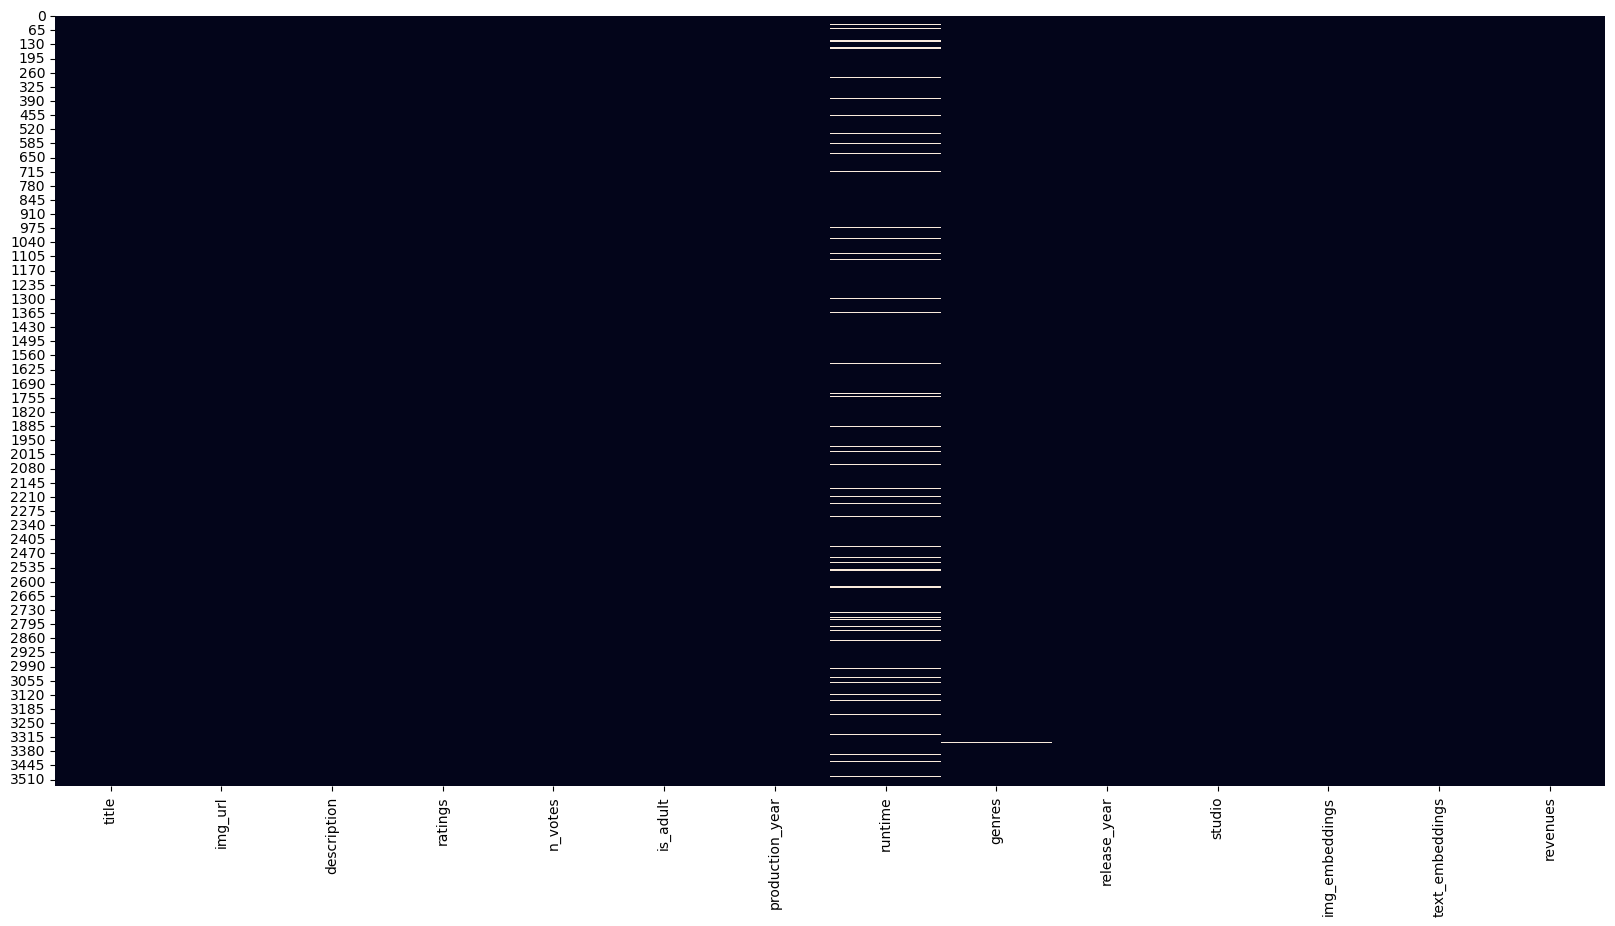

In [21]:
plt.figure(figsize = (20, 10))
sns.heatmap(df.isna(), cbar = False)

Let's check the rows containing missing values

In [22]:
df.loc[df.isna().any(axis=1)]

,title,img_url,description,ratings,n_votes,is_adult,production_year,runtime,genres,release_year,studio,img_embeddings,text_embeddings,revenues
1,Veil of Tears,https://m.media-amazon.com/images/M/MV5BZjMxOD...,Veil of Tears: Directed by William Gereghty. W...,7.9,11.0,0,1996,NaN,"Action,Crime,Drama",2014.0,WF,"[0.51250213, 2.8152602, 0.46308166, 0.29031387...","[-0.6202415, 0.31657028, 0.9992422, -0.9703722...",8.964834e+04
9,Change of Plans,https://m.media-amazon.com/images/M/MV5BMDFhZj...,Change of Plans: Directed by Randy Zisk. With ...,8.2,12.0,0,1992,NaN,"Crime,Drama",2010.0,IFC,"[0.20134872, 3.3128614, 1.3217659, 0.05505188,...","[-0.7538657, 0.43110898, 0.9997868, -0.9895797...",6.305640e+04
38,Clown,https://m.media-amazon.com/images/M/MV5BMjBiOD...,Clown: Directed by Steve Lyons. With Jeff Benn...,8.6,5.0,0,2001,NaN,"Animation,Comedy,Family",2016.0,W/Dim.,"[0.14516667, 0.06064418, 0.15632975, 0.1824489...","[-0.65403396, 0.3780646, 0.999505, -0.97987425...",6.747525e+04
41,Rugrats in Paris: The Movie,https://m.media-amazon.com/images/M/MV5BYzBiNW...,Rugrats in Paris: The Movie: With Cheryl Chase...,6.4,74.0,0,2000,NaN,"Action,Adventure,Comedy",2000.0,Par.,"[0.47641614, 0.82069486, 0.22295909, 0.1736825...","[-0.68661237, 0.37858504, 0.9997692, -0.978913...",1.308007e+08
57,In Bloom,https://m.media-amazon.com/images/M/MV5BYWNmZj...,In Bloom: Directed by Marc Buckland. With Neal...,8.4,16.0,0,2004,NaN,"Drama,Mystery",2014.0,BWP,"[0.30072853, 3.2013667, 0.42100322, 0.10732664...","[-0.787354, 0.46719107, 0.9998723, -0.9922189,...",6.976546e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3492,The Channel,https://m.media-amazon.com/images/M/MV5BNzAwOT...,The Channel: Directed by Jorge Montesi. With S...,7.3,26.0,0,1999,NaN,"Adventure,Drama,Mystery",2016.0,Indic.,"[0.3205554, 0.3742889, 0.11509394, 0.9490364, ...","[-0.60545, 0.31592008, 0.9992462, -0.97367644,...",2.247131e+04
3495,Darshan,https://m.media-amazon.com/images/M/MV5BN2Y2Zj...,Darshan: Directed by Chimanlal Luhar. With Pre...,7.0,8.0,0,1941,NaN,NaN,2006.0,IFC,"[0.056906767, 0.1291496, 0.07299683, 0.0496285...","[-0.7949531, 0.46442604, 0.99984866, -0.991559...",9.642768e+04
3496,Dog Days of Summer,https://m.media-amazon.com/images/M/MV5BMjExNj...,"Dog Days of Summer: Directed by Chris Buck, Cl...",6.2,6.0,0,1993,NaN,"Animation,Comedy,Family",2008.0,MTop,"[0.21031177, 0.622036, 0.10827673, 0.14782186,...","[-0.672096, 0.35698575, 0.9996098, -0.98000515...",7.360684e+03
3504,Area 51,https://m.media-amazon.com/images/M/MV5BMjE4Nz...,"Area 51: With Tom Kane, Joerg Arnu, T.D. Barne...",5.7,6.0,0,2004,NaN,Documentary,2015.0,PARAIN,"[0.68146044, 1.8886466, 2.4086003, 0.9816384, ...","[-0.6459968, 0.31116134, 0.99957985, -0.981476...",9.386019e+03


**Rule of thumb**: _if values are missing at random and percentage of observations with these missing values are less than $5\%$. We can drop them without risking of creating bias in our dataset._

We have $0.3\%$ of entries with missing values for `genres` features. These are random missing values (no reason for these to be missing, probably forgotten) so we can definitelty drop these entries without risk of creating bias in our dataset.
However, for the `runtime` feature, we have ~ $7\%$ of missing values. That's a little bit much for removing all these entries even though they also seem to be random missing values.

We could try to impute by mean or something else.

0    90.0
Name: runtime, dtype: float64


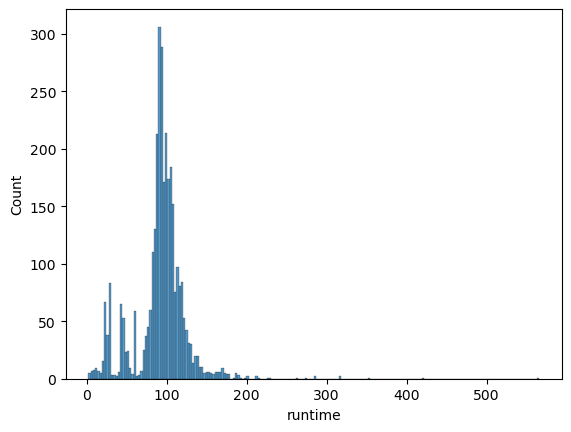

In [23]:
sns.histplot(df["runtime"])

print(df["runtime"].mode())

If data is missing randomly but the rows with these missing values are more than $5\%$ of the dataset, we can use **mean** (in case feature is normally distributed) or **median** (otherwise) imputation. We can also consider **mode** imputation.

However, keep in mind it affects data distribution (in particular the variance is reduced).

In [24]:
print("runtime mean: {}".format(df["runtime"].mean()))
print("runtime median: {}".format(df["runtime"].median()))
print("runtime mode: {}".format(df["runtime"].mode()))

runtime mean: 92.29334554334554
runtime median: 95.0
runtime mode: 0    90.0
Name: runtime, dtype: float64


### Analysis of features

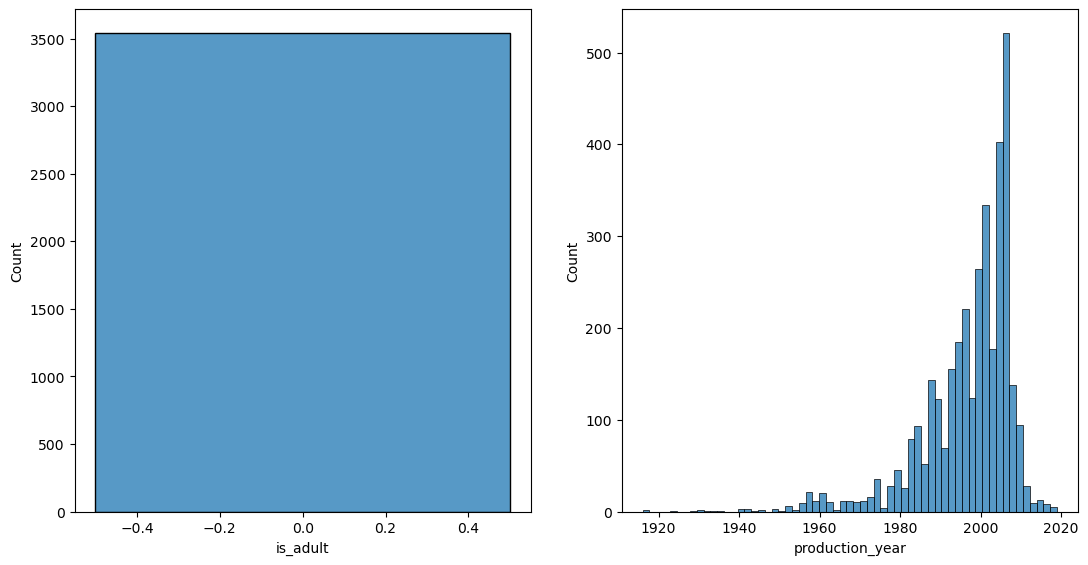

In [25]:
plt.subplots(figsize=(20,30))

i = 1

for col in df.select_dtypes("int"):
    plt.subplot(4,3,i)
    sns.histplot(df[col])
    i += 1

There seems to be only _non-adult_ movies (to confirm later).

Movies were mainly produced between **1990** and **2010**. We have a slightly left skewed distribution but it is more or less **normally distributed**.

In [26]:
df["is_adult"].value_counts()

0    3540
Name: is_adult, dtype: int64

Indeed, we **do not have any movies** for a _mature audience_. 
Therefore, we could drop this column.

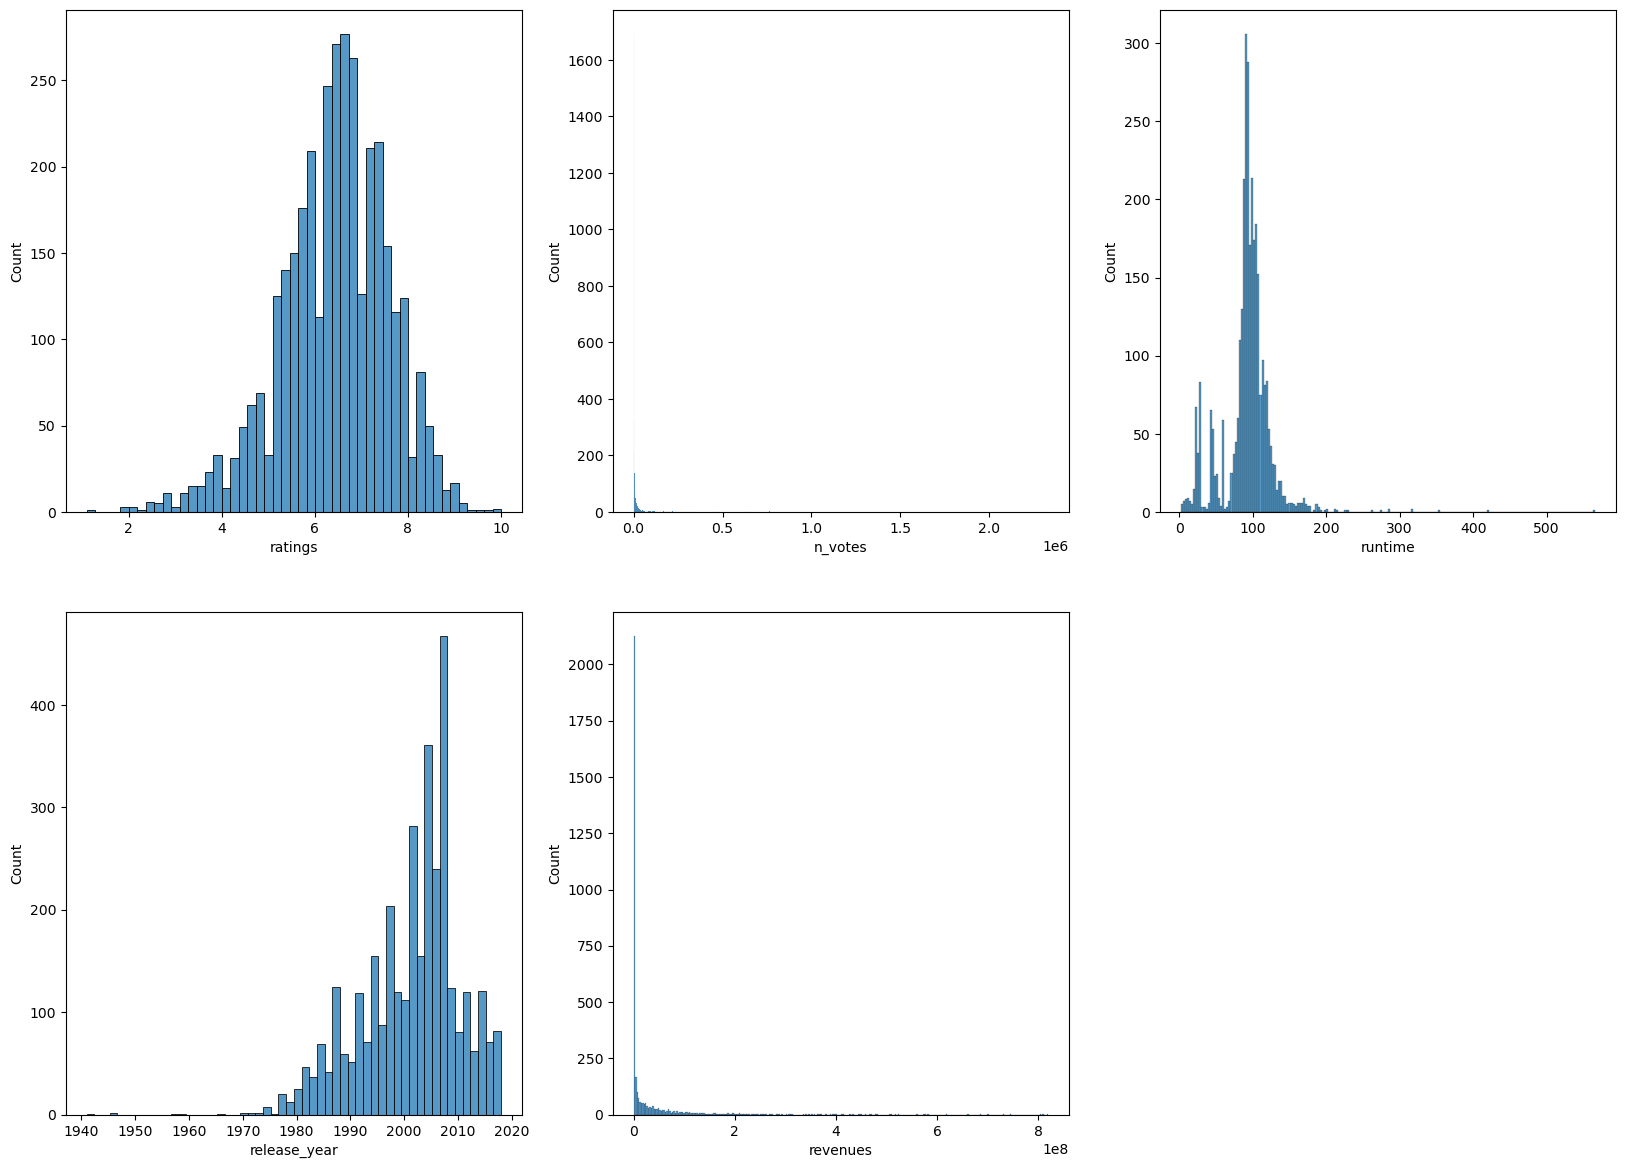

In [27]:
plt.subplots(figsize=(20,30))

i = 1

for col in df.select_dtypes("float"):
    plt.subplot(4, 3, i)
    sns.histplot(df[col])
    i += 1

- `ratings`, `runtime` and `release_year` features are more or less **normally distributed**.

- `ratings` have a mean around **6.5**.

- Most movies were released between **2005** and **2010**. 

- `n_votes` feature and `revenues` target are **heavily right skewed**. We will have to manage that.

### Skewness and outliers analysis

<AxesSubplot:ylabel='n_votes'>

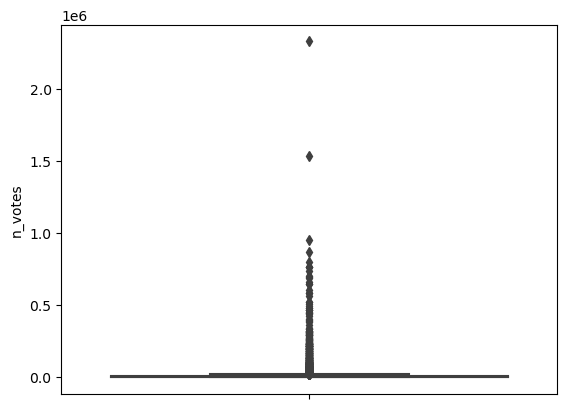

In [28]:
sns.boxplot(y = df["n_votes"])

<AxesSubplot:ylabel='revenues'>

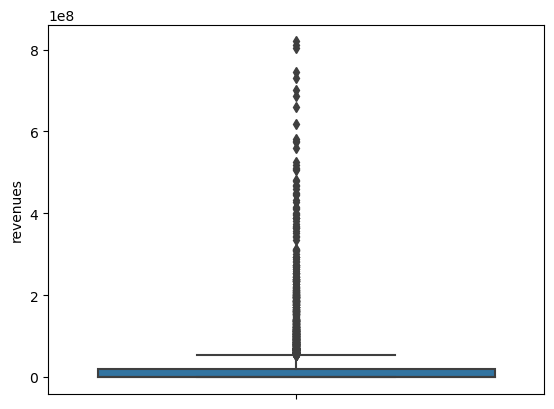

In [29]:
sns.boxplot(y = df["revenues"])

For these two variables, 50% of the data are concentrated on a small range of values. But they contain a lot of outliers until pretty high values (that's why distribution is heavily right skewed).

In [30]:
df.describe()

,ratings,n_votes,is_adult,production_year,runtime,release_year,revenues
count,3540.000000,3.540000e+03,3540.0,3540.000000,3276.000000,3540.000000,3.540000e+03
mean,6.426582,2.337422e+04,0.0,1996.867232,92.293346,2001.375706,2.808340e+07
std,1.166002,8.597705e+04,0.0,11.818582,32.619486,9.236620,7.322589e+07
min,1.100000,5.000000e+00,0.0,1916.000000,2.000000,1941.000000,1.303869e+02
25%,5.800000,1.577500e+02,0.0,1992.000000,85.000000,1996.000000,4.155345e+04
50%,6.500000,1.412000e+03,0.0,2000.000000,95.000000,2003.000000,5.019854e+05
75%,7.200000,9.424500e+03,0.0,2005.000000,106.000000,2007.000000,2.144866e+07
max,10.000000,2.332286e+06,0.0,2019.000000,566.000000,2018.000000,8.199476e+08


Let's analyze the range of the different numericals features

In [31]:
(df.select_dtypes(include=["int64", "float64"]).max() - df.select_dtypes(include=["int64", "float64"]).min()).round(decimals=3)

ratings            8.900000e+00
n_votes            2.332281e+06
is_adult           0.000000e+00
production_year    1.030000e+02
runtime            5.640000e+02
release_year       7.700000e+01
revenues           8.199474e+08
dtype: float64

Finally we count the number of unique values for the 2 categorical features `genres` and `studio`.

In [32]:
df["genres"].describe()

count      3536
unique      351
top       Drama
freq        313
Name: genres, dtype: object

`studio` feature contains list of maximum 3 most representative genres for each movies so there are many differents list of genres which does not mean there a as much different genres. We should preprocess them before then count how many different genres there are. 
However, we can expect there shouldn't be too many differents.

In [33]:
df["studio"].describe()

count     3540
unique     498
top         WB
freq       184
Name: studio, dtype: object

We see there are a lof of different studios, therefore, it will result in a lof of features if we One-Hot encode them. As a consequence, we would explose the dimensionnality of the datas and there would be more risk to overfit (curse of dimensionnality). Better to Label encode ?

## Preprocessing (part 1)

### Remove duplicated observations and preprocessing missing values

In [34]:
def preprocess_duplicated_and_missing(df):
	# drop duplicated values
	df.drop_duplicates(subset=df.columns.difference(["revenues"]), keep="first", inplace=True)

	# drop observations with missing genres
	df.dropna(subset=["genres"], axis=0, inplace=True)

	# impute observations with missing runtime (because > 5% of missing values)
	# replace by the mean (since runtime feature is not too for from a Gaussian)
	df["runtime"].fillna(df["runtime"].mean(), inplace=True)

	print("[X] Removing duplicated and missing values")
	return df

### Remove (obvious) irrelevant/redundant features

In [35]:
def preprocess_irrelevant_features(df):
	# drop `img_url` and `description` since we have the embeddings
	df.drop(["img_url", "description"], axis=1, inplace=True)

	# we do not have movies for mature audience so feature `is_adult` has variance 0
	df.drop(["is_adult"], axis=1, inplace=True)

	print("[X] Removing irrelevant features")
	return df

### One-Hot Encode genres feature

In [36]:
def one_hot_encode_genres_feature(df):
	# separate all genres into one big list of list of genres
	genres_list = df["genres"].str.split(",").tolist()

	unique_genres = []

	# retrieve each genre
	for sublist in genres_list:
		for genre in sublist:
			if genre not in unique_genres:
				unique_genres.append(genre)

	# sort
	unique_genres = sorted(unique_genres)

	# one hot encode movies genres
	df = df.reindex(df.columns.tolist() + unique_genres, axis=1, fill_value=0)

	for index, row in df.iterrows():
		for genre in row["genres"].split(","):
			df.loc[index, genre] = 1

	# drop old genres column
	df.drop("genres", axis=1, inplace=True)

	print("[X] One-Hot encoding")
	return df

### Label Encode studio feature

In [37]:
label_encoder_studio = LabelEncoder()

def label_encode_studio_feature(df):
	df["studio"] = label_encoder_studio.fit_transform(df["studio"].to_numpy())

	print("[X] Label encoding")
	return df

### Minor fixes

In [38]:
def other_fixes(df):
	# it does not make sense to have `release_year` and `n_votes` features as type float
	# let's convert them into int
	df["release_year"] = df["release_year"].astype(int)
	#df["n_votes"] = df["n_votes"].astype(int)

	# in notebook, I dropped this feature at the end of first part of preprocessing
	# but I'm not sure why
	df.drop("title", axis=1, inplace=True)

	print("[X] Minor fixes")
	return df

In [39]:
def preprocess(df, dataset_name):
	print(f"PREPROCESSING {dataset_name} 1/2...")
	print("--------------------------")
	df = preprocess_duplicated_and_missing(df)
	df = preprocess_irrelevant_features(df)

	df = one_hot_encode_genres_feature(df)
	df = label_encode_studio_feature(df)
	df = other_fixes(df)
	return df

df = preprocess(df, "modeling dataset")
X2 = preprocess(X2, "prediction dataset")

PREPROCESSING modeling dataset 1/2...
--------------------------
[X] Removing duplicated and missing values
[X] Removing irrelevant features
[X] One-Hot encoding
[X] Label encoding
[X] Minor fixes
PREPROCESSING prediction dataset 1/2...
--------------------------
[X] Removing duplicated and missing values
[X] Removing irrelevant features
[X] One-Hot encoding
[X] Label encoding
[X] Minor fixes


## Preprocessing (part 2)

### Handle outliers

In [40]:
def remove_outliers(X_train):
	pass

### Standardizing

Standardizing data with `Standadardizer` or `Normalizer` is not a good idea with skewed data. 
Since we cannot remove outliers of `n_votes` feature, we use `RobustScaler` that works better with skewed data.

In [41]:
robust_scaler = RobustScaler()

def standardize(X_train, X_test):
	# fit the scaler on training dataset
	X_train_scaled = robust_scaler.fit_transform(X_train)

	# apply the scaler on testing dataset (and so avoid introducing bias)
	X_test_scaled = robust_scaler.transform(X_test)

	# should do the same on X2 

	X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
	X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

	return X_train, X_test

### Extracting features from embeddings

In [46]:
def extract_embeddings_features(embeddings):
	"""
	Args:
		embeddings (pd.Series): Pandas Series of string representation of feature vectors.
	Return:
		(np.ndarray): feature matrix of dimension (n_observations, n_features)
	"""
	n = embeddings.shape[0]
	embeddings_matrix = []

	for i in range(n):
		# embeddings are encoded as string representation of vector
		# convert these into list
		# Note: should'nt set ast.litteral_eval(...) to a variable, then append to the list
		# since it would consume a huge quantity of ram.
		# better directly appending
		embeddings_matrix.append(ast.literal_eval(embeddings.iloc[i]))

	return embeddings_matrix

### Running PCA on embeddings

Embeddings are feature vectors which means each number in the vector represent a feature. 
For example, it could be `feature_vector = [R, G, B]` where `R`, `G` and `B` are integers value and represent red, green, blue quantity of an image. 
We extract these features and put them into columns. We should note it's gonna give us a very high dimension dataset.

In [48]:

def pca_on_embeddings(train_embeddings_matrix, test_embeddings_matrix, train_index, test_index, prefix, total_variance_explained = 0.95):
		scaler = StandardScaler()

		n_features_before_pca = len(train_embeddings_matrix[0])

		# standardize data
		train_embeddings_matrix = scaler.fit_transform(train_embeddings_matrix)
		test_embeddings_matrix = scaler.transform(test_embeddings_matrix)

		pca = PCA(n_components=total_variance_explained)

		# run pca
		train_embeddings_matrix = pca.fit_transform(train_embeddings_matrix)
		test_embeddings_matrix = pca.transform(test_embeddings_matrix)

		print(f"successfully reduced from {n_features_before_pca} features to {len(train_embeddings_matrix[0])} features keeping {total_variance_explained * 100}% of variance explained")

		train_embeddings_df = pd.DataFrame(train_embeddings_matrix, index=train_index).add_prefix(prefix)
		test_embeddings_df = pd.DataFrame(test_embeddings_matrix, index=test_index).add_prefix(prefix)

		return train_embeddings_df, test_embeddings_df

In [55]:
def special_preprocess(X, Y):
	print("PREPROCESSING 2/2...")
	print("--------------------------")

	X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size = 0.8, test_size = 0.2, shuffle = True, random_state = 0)

	print(f"training dataset dimension: X_train: {X_train.shape}, y_train: {y_train.shape}")
	print(f"testing dataset dimension: X_test: {X_test.shape}, y_test: {y_test.shape}")

	# remove outliers only on train set
	# as test set should be representative of the reality
	remove_outliers(X_train)

	# extract feature vectors
	X_train_img_embeddings = extract_embeddings_features(X_train["img_embeddings"])
	X_test_img_embeddings = extract_embeddings_features(X_test["img_embeddings"])

	X_train_text_embeddings = extract_embeddings_features(X_train["text_embeddings"])
	X_test_text_embeddings = extract_embeddings_features(X_test["text_embeddings"])

	X_train_img_df, X_test_img_df = pca_on_embeddings(X_train_img_embeddings, X_test_img_embeddings, X_train.index, X_test.index, prefix="img_feature", total_variance_explained=0.8)

	X_train_text_df, X_test_text_df = pca_on_embeddings(X_train_text_embeddings, X_test_text_embeddings, X_train.index, X_test.index, prefix="text_feature", total_variance_explained=0.8)

	# drop unnecessary features
	X_train.drop(["img_embeddings", "text_embeddings"], axis=1, inplace=True)
	X_test.drop(["img_embeddings", "text_embeddings"], axis=1, inplace=True)

	# standardize other features
	X_train, X_test = standardize(X_train, X_test)

	X_train = pd.concat([X_train, X_train_img_df, X_train_text_df], axis=1)
	X_test = pd.concat([X_test, X_test_img_df, X_test_text_df], axis=1)

	# should also extract features for X2

	return X_train, X_test

X = df.drop("revenues", axis=1)
Y = df["revenues"]

special_preprocess(X, Y)

PREPROCESSING 2/2...
--------------------------
training dataset dimension: X_train: (2484, 34), y_train: (2484,)
testing dataset dimension: X_test: (621, 34), y_test: (621,)


## Model

We're gonna build regression models :
- Linear regression
- K-Nearest Neighbors 
- MLP
- One other non-linear method (can be one not seen during the course)

We're gonna do **feature selection** and **model selection**.
/!\ model selection can require a lot of computation time /!\

We're gonna validate the model.

### Feature selection : Filter Method

We want to remove redundant or irrelevant features to improve computational efficiency and reduce the risk of overfitting.
As I understand, there's multiple ways to selection features via filter method. As a reminder, filter method is independent of any machine learning model but does not take into account feature redundancy. 

Some of them are:
- `Chi-Square` and `ANOVA`: for categorical variables and categorical targets    
- `Correlation matrix`: for continuous variables, continuous target and linear model    
- `Mutual information`: for continuous variables, continuous target and non-linear model     

Since we're dealing with continuous target and we will train linear and non-linear models, we use the two last one.

In [ ]:
X1.dtypes

#### Correlation matrix (linear models)

ratings            0.105347
n_votes            0.468389
production_year   -0.073992
runtime            0.094425
release_year      -0.164917
                     ...   
Short              0.098263
Sport              0.032736
Thriller           0.005551
War               -0.010494
Western           -0.005751
Length: 2848, dtype: float64


IndexError: Inconsistent shape between the condition and the input (got (2848, 1) and (2848,))

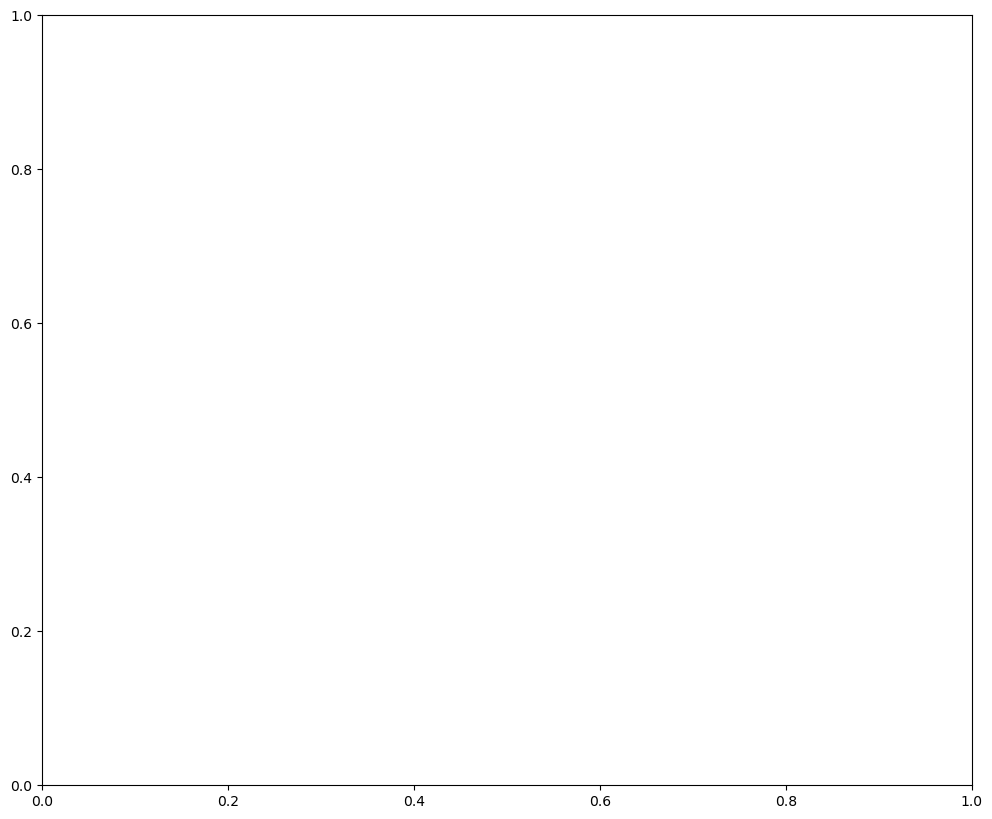

In [ ]:
fig = plt.subplots(figsize = (12,10))

corr_with_target = X_train.corrwith(y_train)

print(corr_with_target)
sns.heatmap(corr_with_target, annot=True)

In [ ]:
def select_features_correlation(X_train, y_train, X_test, k_features):
    # select k best features according to correlation matrix
    corr_with_target = X_train.corrwith(y_train)

    k_best = corr_with_target[0:k_features-1]
    k_best = [feature_name for feature_name, correlation_with_target in k_best.items() if feature_name != "revenues"]
    print(k_best)
    
    X_train_filtered = X_train[k_best]
    X_test_filtered = X_test[k_best]
    
    return X_train_filtered, X_test_filtered

select_features_correlation(X_train, y_train, X_test, 10)

['ratings', 'n_votes', 'production_year', 'runtime', 'release_year', 'studio', 'img_embeddings1', 'img_embeddings2', 'img_embeddings3']


(       ratings   n_votes  production_year   runtime  release_year  studio  \
 1860  0.857143 -0.152636         0.142857 -3.631579      0.833333     371   
 2459 -0.642857 -0.118577        -0.357143 -0.315789      0.583333     169   
 2508 -0.857143 -0.005466        -0.642857 -0.210526     -0.916667     470   
 1288  0.500000  6.967118        -1.214286 -0.368421     -1.666667     461   
 330   0.214286  0.332436        -0.357143 -0.105263     -0.666667     330   
 ...        ...       ...              ...       ...           ...     ...   
 783  -1.214286  0.406358         0.071429  0.105263     -0.166667     259   
 858   1.000000 -0.149777         0.357143  0.473684      0.166667     233   
 1759 -0.214286  0.424523         0.357143  3.368421      0.166667     493   
 2908 -2.142857 -0.102599         0.214286  0.842105      0.000000     102   
 3057  0.642857 -0.001682        -1.285714 -0.105263     -1.666667     274   
 
       img_embeddings1  img_embeddings2  img_embeddings3  
 18

#### Mutual information (non-linear models)

In [ ]:
def select_features_MI(X_train, y_train, X_test, k_features):
    # select k best features according to MI
    k_best = SelectKBest(mutual_info_regression, k=k_features)
    k_best.fit(X_train, y_train)
    print(X_train.columns[k_best.get_support()])
    
    X_train_filtered = X_train[X_train.columns[k_best.get_support()]]
    X_test_filtered = X_test[X_train.columns[k_best.get_support()]]
    
    return X_train_filtered, X_test_filtered

select_features_MI(X_train, y_train, X_test, 10)

Index(['n_votes', 'runtime', 'release_year', 'studio', 'img_embeddings1523',
       'img_embeddings1642', 'text_embeddings122', 'text_embeddings239',
       'text_embeddings305', 'text_embeddings608'],
      dtype='object')


(       n_votes   runtime  release_year  studio  img_embeddings1523  \
 1860 -0.152636 -3.631579      0.833333     371            0.153401   
 2459 -0.118577 -0.315789      0.583333     169            0.860543   
 2508 -0.005466 -0.210526     -0.916667     470            0.093287   
 1288  6.967118 -0.368421     -1.666667     461            1.167165   
 330   0.332436 -0.105263     -0.666667     330           -0.610254   
 ...        ...       ...           ...     ...                 ...   
 783   0.406358  0.105263     -0.166667     259            1.197402   
 858  -0.149777  0.473684      0.166667     233           -0.488953   
 1759  0.424523  3.368421      0.166667     493           -0.533915   
 2908 -0.102599  0.842105      0.000000     102           -0.091429   
 3057 -0.001682 -0.105263     -1.666667     274           -0.294378   
 
       img_embeddings1642  text_embeddings122  text_embeddings239  \
 1860           -0.273817           -0.323497            0.319073   
 2459   

### Feature selection: Wrapper Method

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

forest = RandomForestRegressor(n_estimators=500, random_state=0)
forest.fit(X1_train, Y1_train)

sfm = SelectFromModel(forest, threshold=0.1, prefit=True)

X1_selected = sfm.transform(X1_train)

feat_labels = X1_train.columns
importances = forest.feature_importances_

for i in range(X1_selected.shape[1]):
    print("%2d) %-*s %f" % (i + 1, feat_labels[indices[i]], importances[indices[i]]))

### Model selection

In [ ]:
from sklearn.linear_model import LinearRegression

X_train_filtered, X_test_filtered = select_features_correlation(X_train, y_train, X_test, k_features=10)

lr = LinearRegression()

# train the model on training set
lr.fit(X_train_filtered, y_train)

# predict values with testing set
y_pred = lr.predict(X_test_filtered)

# compare predicted values with the testing target using mse
mse = mean_squared_error(y_test, y_pred)

mse

['ratings', 'n_votes', 'production_year', 'runtime', 'release_year', 'studio', 'img_embeddings1', 'img_embeddings2', 'img_embeddings3']


7.2879096654372

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor()
knn.fit(X1_train, Y1_train)

In [ ]:
from torch import nn
from skorch import NeuralNetRegressor

## Prediction

We're gonna make prediction about the revenue of movies present in `X2.csv`.